In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('datacubes/tabuyo/2023/pngs/mini_v3'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

datacubes/tabuyo/2023/pngs/mini_v3/2023-03-15.png
datacubes/tabuyo/2023/pngs/mini_v3/2023-07-10.png
datacubes/tabuyo/2023/pngs/mini_v3/2023-01-24.png
datacubes/tabuyo/2023/pngs/mini_v3/2023-10-01.png
datacubes/tabuyo/2023/pngs/mini_v3/2023-03-02.png
datacubes/tabuyo/2023/pngs/mini_v3/2023-07-25.png
datacubes/tabuyo/2023/pngs/mini_v3/2023-02-05.png
datacubes/tabuyo/2023/pngs/mini_v3/2023-04-09.png
datacubes/tabuyo/2023/pngs/mini_v3/2023-06-28.png
datacubes/tabuyo/2023/pngs/mini_v3/2023-07-18.png
datacubes/tabuyo/2023/pngs/mini_v3/2023-07-28.png
datacubes/tabuyo/2023/pngs/mini_v3/2023-08-14.png
datacubes/tabuyo/2023/pngs/mini_v3/2023-05-11.png
datacubes/tabuyo/2023/pngs/mini_v3/2023-02-10.png
datacubes/tabuyo/2023/pngs/mini_v3/2023-08-22.png
datacubes/tabuyo/2023/pngs/mini_v3/2023-08-04.png
datacubes/tabuyo/2023/pngs/mini_v3/2023-12-22.png
datacubes/tabuyo/2023/pngs/mini_v3/2023-08-24.png
datacubes/tabuyo/2023/pngs/mini_v3/2023-10-03.png
datacubes/tabuyo/2023/pngs/mini_v3/2023-01-04.png


In [2]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

2024-04-16 13:41:39.409620: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-16 13:41:39.437438: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-16 13:41:39.881657: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Segmentation Models: using `tf.keras` framework.


In [3]:
import cv2
import numpy as np
import glob as gb
from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
from tensorflow.keras.metrics import MeanIoU

from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()

/home/bea/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [4]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU') 

for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

2024-04-16 13:41:40.603462: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 13:41:40.606547: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [5]:
images_directory = 'datacubes/tabuyo/2023/pngs/mini_v3'
patch_size = 64

image_dataset = []  
images = os.listdir(images_directory)  #List of all image names in this subdirectory

for i, image_name in enumerate(images):  
    if image_name.endswith(".png"):   #Only read png images...
        
        image = cv2.imread(images_directory+"/"+image_name, 1)  #Read each image as BGR
        SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
        SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
        image = Image.fromarray(image)
        image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
        #image = image.resize((SIZE_X, SIZE_Y))  #Try NOT to resize for semantic segmentation
        image = np.array(image)      

        image_dataset.append(image)       

'''
        #Extract patches from each image
        print("Now patchifying image:", images_directory+"/"+image_name)
        patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap

        for i in range(patches_img.shape[0]):
            for j in range(patches_img.shape[1]):
                
                single_patch_img = patches_img[i,j,:,:]
                
                #Use minmaxscaler instead of just dividing by 255. 
                single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                
                #single_patch_img = (single_patch_img.astype('float32')) / 255. 
                single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.                               
                image_dataset.append(single_patch_img)
                '''

'\n        #Extract patches from each image\n        print("Now patchifying image:", images_directory+"/"+image_name)\n        patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap\n\n        for i in range(patches_img.shape[0]):\n            for j in range(patches_img.shape[1]):\n                \n                single_patch_img = patches_img[i,j,:,:]\n                \n                #Use minmaxscaler instead of just dividing by 255. \n                single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)\n                \n                #single_patch_img = (single_patch_img.astype(\'float32\')) / 255. \n                single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.                               \n                image_dataset.append(single_patch_img)\n                '

In [6]:
images = os.listdir(images_directory)
images

['2023-03-15.png',
 '2023-07-10.png',
 '2023-01-24.png',
 '2023-10-01.png',
 '2023-03-02.png',
 '2023-07-25.png',
 '2023-02-05.png',
 '2023-04-09.png',
 '2023-06-28.png',
 '2023-07-18.png',
 '2023-07-28.png',
 '2023-08-14.png',
 '2023-05-11.png',
 '2023-02-10.png',
 '2023-08-22.png',
 '2023-08-04.png',
 '2023-12-22.png',
 '2023-08-24.png',
 '2023-10-03.png',
 '2023-01-04.png',
 '2023-06-25.png',
 '2023-08-09.png',
 '2023-01-11.png',
 '2023-12-02.png',
 '2023-04-19.png',
 '2023-09-13.png',
 '2023-09-28.png',
 '2023-09-01.png',
 '2023-10-06.png',
 '2023-09-23.png',
 '2023-12-15.png',
 '2023-09-26.png',
 '2023-12-20.png',
 '2023-02-03.png',
 '2023-06-30.png',
 '2023-04-06.png',
 '2023-02-15.png',
 '2023-07-30.png',
 '2023-07-20.png',
 '2023-11-22.png',
 '2023-02-18.png',
 '2023-08-07.png',
 '2023-08-19.png',
 '2023-07-03.png',
 '2023-10-08.png',
 '2023-01-31.png',
 '2023-06-15.png',
 '2023-07-13.png',
 '2023-01-29.png',
 '2023-03-27.png',
 '2023-08-17.png']

In [7]:
mask_path = 'datacubes/tabuyo/2023/mask_testing/mini_mascara_2023.png'
mask_dataset = []  

#Mask preprocessing only needs to be executed once
mask = cv2.imread(mask_path, 1)  #Read each image as Grey (or color but remember to map each color to an integer)
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

resized_mask = cv2.resize(mask, (287, 163)) # Resize the mask to the images' shape     

SIZE_X = (resized_mask.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
SIZE_Y = (resized_mask.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
mask = Image.fromarray(resized_mask)
mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
#mask = mask.resize((SIZE_X, SIZE_Y))  #Try NOT to resize for semantic segmentation
mask = np.array(mask)      

for mask_name in (images): # hacer tantas mascaras como imagenes
    #Extract patches from each image
    mask_dataset.append(mask) 

    '''
    print("Now patchifying mask:", mask_name)
    patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):
            
            single_patch_mask = patches_mask[i,j,:,:]
            #single_patch_img = (single_patch_img.astype('float32')) / 255. #No need to scale masks, but you can do it if you want
            single_patch_mask = single_patch_mask[0] #Drop the extra unecessary dimension that patchify adds.                               
            mask_dataset.append(single_patch_mask) 
'''

In [8]:
image.shape

(128, 256, 3)

In [9]:
mask.shape

(128, 256, 3)

In [10]:
image_dataset = np.array(image_dataset)
print('Images', image_dataset.shape)

mask_dataset =  np.array(mask_dataset)
print('Masks', mask_dataset.shape)

Images (51, 128, 256, 3)
Masks (51, 128, 256, 3)


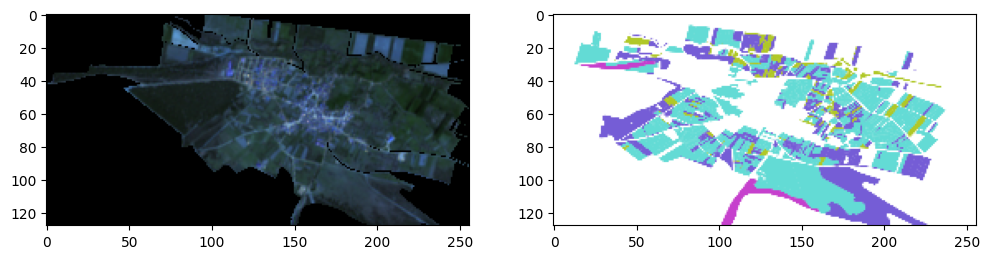

In [11]:
import random
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.imshow(image_dataset[image_number])

plt.subplot(122)
plt.imshow(mask_dataset[image_number])

plt.show()

In [ ]:
Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

Road = '#6EC1E4'.lstrip('#') 
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

Vegetation =  'FEDD3A'.lstrip('#') 
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

Water = 'E2A929'.lstrip('#') 
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

Unlabeled = '#9B9B9B'.lstrip('#') 
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155



In [ ]:
label = single_patch_mask
label.shape

In [ ]:
# Now replace RGB to integer values to be used as labels.
#Find pixels with combination of RGB for the above defined arrays...
#if matches then replace all values in that pixel with a specific integer
def rgb_to_2D_label(label):
    """
    Suply our labale masks as input in RGB format. 
    Replace pixels with specific RGB values ...
    """
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == Building,axis=-1)] = 0
    label_seg [np.all(label==Land,axis=-1)] = 1
    label_seg [np.all(label==Road,axis=-1)] = 2
    label_seg [np.all(label==Vegetation,axis=-1)] = 3
    label_seg [np.all(label==Water,axis=-1)] = 4
    label_seg [np.all(label==Unlabeled,axis=-1)] = 5
    
    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels
    
    return label_seg

In [ ]:
labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)    

labels = np.array(labels)   

 


In [ ]:
labels.shape

In [ ]:
labels = np.expand_dims(labels, axis=3)


In [ ]:
labels.shape


In [ ]:
print("Unique labels in label dataset are: ", np.unique(labels))


In [ ]:
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()


In [ ]:
n_classes = len(np.unique(labels))
from tensorflow.keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)

In [ ]:
weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
dice_loss = sm.losses.DiceLoss(class_weights=weights) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)  



In [ ]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras import backend as K

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

In [ ]:
def multi_unet_model(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.2)(c1)  # Original 0.1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)  # Original 0.1
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)  # Original 0.1
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)  # Original 0.1
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    return model


In [ ]:
metrics=['accuracy', jacard_coef]

In [ ]:
model= multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH,IMG_CHANNELS=IMG_CHANNELS)

In [ ]:
model.summary()


In [ ]:
model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping ,ReduceLROnPlateau ,ModelCheckpoint
EarlyStop=EarlyStopping(patience=10,restore_best_weights=True)
Reduce_LR=ReduceLROnPlateau(monitor='val_accuracy',verbose=2,factor=0.5,min_lr=0.00001)
model_check=ModelCheckpoint('model.hdf5',monitor='val_loss',verbose=1,save_best_only=True)
callback=[EarlyStop , Reduce_LR,model_check]

In [ ]:
history1 = model.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=30, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

In [ ]:
history = history1
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
acc = history.history['jacard_coef']
val_acc = history.history['val_jacard_coef']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

In [ ]:
#IOU
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)


In [ ]:
#Using built in keras function for IoU
from tensorflow.keras.metrics import MeanIoU
n_classes = 6
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())


In [ ]:
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()
